# Spark Streaming et fenêtres

Use case : Flight tracking with OpenSky

### Imports

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, count, desc
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType, TimestampType, FloatType
from pyspark.sql.functions import col, desc, sum, mean, min, max, lit, coalesce, bucket, col, window, avg
from matplotlib.pylab import mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [16]:
conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")


sc = SparkContext.getOrCreate(conf=conf)

# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)

/opt/conda/lib/python3.12/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Configuration kafka et spark

In [17]:
flights_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-flights") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

In [18]:
schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("firstSeen", LongType(), True),
    StructField("estDepartureAirport", StringType(), True),
    StructField("lastSeen", LongType(), True),
    StructField("estArrivalAirport", StringType(), True),
    StructField("estDepartureAirportHorizDistance", LongType(), True),
    StructField("estDepartureAirportVertDistance", LongType(), True),
    StructField("estArrivalAirportHorizDistance", LongType(), True),
    StructField("estArrivalAirportVertDistance", LongType(), True),
    StructField("departureAirportCandidatesCount", LongType(), True),
    StructField("arrivalAirportCandidatesCount", LongType(), True)
])

flights_json = flights_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")


## Requêtes en mode batch, avec état.
### Mode batch avec fenêtre

In [ ]:
# Parse Kafka messages
parsed_stream = flights_df.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select(
        col("data.lastSeen").cast(TimestampType()).alias("ArrivalTime"),
        col("data.estArrivalAirport").alias("Airport")
    )

# Compute number of arrivals over a 60-minute window
rolling_numbers = parsed_stream \
    .groupBy(window(col("ArrivalTime"), "60 minutes")) \
    .count() \
    .select(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("count").alias("num_arrivals")
    ).orderBy("window_start")

# Collect the result as a Pandas DataFrame
pandas_df = rolling_numbers.toPandas()
pandas_df

g = sns.lineplot(data=pandas_df, x="window_start", y="num_arrivals")
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m\n%H:%M'))

DataFrame[window_start: timestamp, window_end: timestamp, num_arrivals: bigint]

### Mode batch sans fenêtre

In [12]:
flight_counts = flights_json \
    .groupBy("estDepartureAirport", "estArrivalAirport") \
    .count() \
    .withColumnRenamed("count", "flight_count")

# Créer un DataFrame pour les arêtes (vols)
nbVols = flight_counts.select(
    col("estDepartureAirport").alias("src"),
    col("estArrivalAirport").alias("dst"),
    col("flight_count")
)
# on se limite au 15 aéroports les plus fréquentés
top_n = 15

# Identifier les aéroports les plus fréquentés (combinaison de départs et arrivées)
top_airports = (
    flight_counts.select("estDepartureAirport").union(flight_counts.select("estArrivalAirport"))
    .groupBy("estDepartureAirport").count()
    .orderBy(desc("count"))
    .limit(top_n)
    .select("estDepartureAirport").collect()
)
top_airport_codes = [row['estDepartureAirport'] for row in top_airports]

# Filtrer le dataframe pour n'inclure que les vols entre ces aéroports principaux
filtered_counts = flight_counts.filter(
    (col("estDepartureAirport").isin(top_airport_codes)) & 
    (col("estArrivalAirport").isin(top_airport_codes))
)

filtered_counts

25/02/18 14:10:38 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 14:10:38 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


DataFrame[estDepartureAirport: string, estArrivalAirport: string, flight_count: bigint]

25/02/18 14:13:24 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 14:13:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+----+------------+
| src| dst|flight_count|
+----+----+------------+
|NULL|NULL|         128|
|NULL|KMIA|          39|
|NULL|VIDP|          36|
|KFXE|KFXE|          35|
|KMIA|NULL|          29|
|NULL|LTFM|          23|
|NULL|SBGR|          23|
|NULL|MMMX|          22|
|KHWO|KHWO|          21|
|NULL|SABE|          18|
|NULL|KFLL|          18|
|KFFZ|KFFZ|          17|
|MMMX|NULL|          16|
|NULL|KFXE|          16|
|SPJC|NULL|          16|
+----+----+------------+



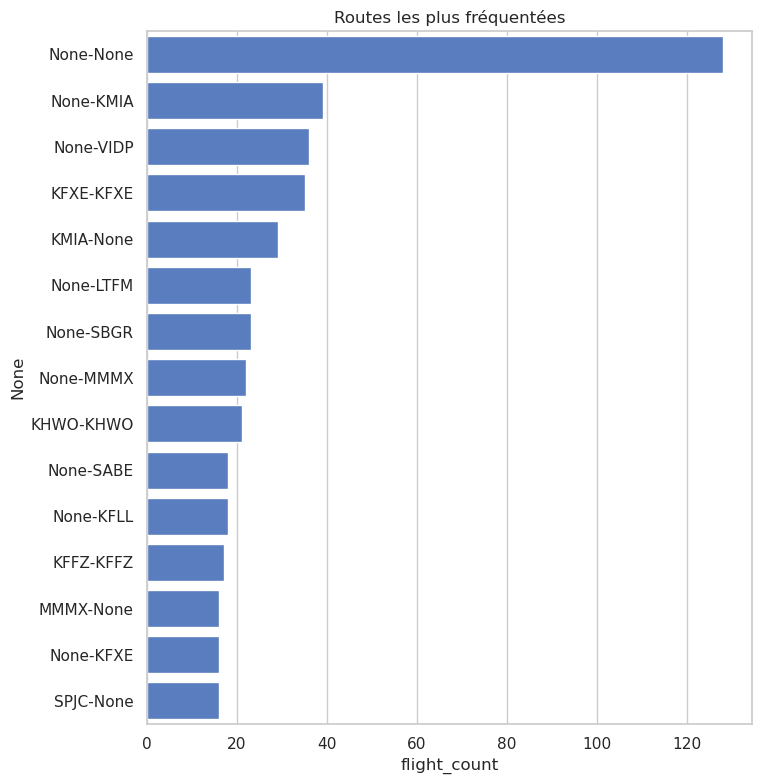

In [ ]:

# Trouver les routes les plus empruntées
top_routes = nbVols.orderBy(desc("flight_count")).limit(top_n)
top_routes.show()

# Convertir en pandas pour visualisation avec Seaborn
top_routes_pd = top_routes.toPandas()

# Créer des visualisations
plt.figure(figsize=(14, 8))

# Graphique des routes les plus fréquentées
plt.subplot(1, 2, 2)
sns.boxplot
sns.barplot(x="flight_count", y=top_routes_pd.apply(lambda x: f"{x['src']}-{x['dst']}", axis=1), 
            data=top_routes_pd, orient="h")
plt.title("Routes les plus fréquentées")
plt.tight_layout()

plt.savefig("aviation_network_analysis.png")
plt.show()
plt.close()

In [14]:
# Convertir en pandas pour le pivot
matrix_data = filtered_counts.toPandas()

# Créer la matrice pivot
flight_matrix = matrix_data.pivot(index='estDepartureAirport', columns='estArrivalAirport', values='flight_count')
flight_matrix = flight_matrix.fillna(0)  # Remplacer les NaN par 0

# Créer le heatmap
plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    flight_matrix,
    annot=True,           # Afficher les valeurs
    fmt='g',              # Format des nombres (entiers)
    cmap='YlGnBu',        # Palette de couleurs (jaune-vert-bleu)
    linewidths=0.5,       # Lignes entre les cellules
    cbar_kws={'label': 'Nombre de vols'}
)

# Ajuster les étiquettes et le titre
plt.title('Nombre de vols entre les principaux aéroports', fontsize=16)
plt.xlabel('Destinations', fontsize=12)
plt.ylabel('Origines', fontsize=12)

# Rotation des étiquettes pour la lisibilité
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder et afficher
plt.savefig("/tmp/flight_heatmap_origin_destination.png", dpi=300)
# plt.show()
plt.close()

# Obtenir quelques statistiques sur cette matrice
nonzero_routes = (flight_matrix > 0).sum().sum()
total_possible_routes = len(top_airport_codes) * len(top_airport_codes)
connectivity_ratio = nonzero_routes / total_possible_routes

print(f"Parmi les {top_n} principaux aéroports:")
print(f"Nombre total de routes possibles: {total_possible_routes}")
print(f"Nombre de routes effectivement desservies: {nonzero_routes}")
print(f"Ratio de connectivité: {connectivity_ratio:.2%}")
print(f"Nombre moyen de vols par route active: {flight_matrix.sum().sum() / nonzero_routes:.1f}")

25/02/18 14:14:10 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Parmi les 15 principaux aéroports:
Nombre total de routes possibles: 225
Nombre de routes effectivement desservies: 18
Ratio de connectivité: 8.00%
Nombre moyen de vols par route active: 6.2


## Requête avec SparkSQL

In [7]:
# Enregistrer le DataFrame en tant que table temporaire
flights_json.createOrReplaceTempView("flights")

# Top 5 de la correspondance la plus fréquente
query = """
SELECT estDepartureAirport, estArrivalAirport, COUNT(*) as count
FROM flights
WHERE estDepartureAirport IS NOT NULL AND estArrivalAirport IS NOT NULL AND estDepartureAirport != estArrivalAirport
GROUP BY estDepartureAirport, estArrivalAirport
ORDER BY count DESC
LIMIT 5
"""

top_5_couples = sql_context.sql(query)

# Afficher les résultats
top_5_couples.show()

25/02/18 13:27:08 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------------------+-----------------+-----+
|estDepartureAirport|estArrivalAirport|count|
+-------------------+-----------------+-----+
|               KE25|             KDVT|   13|
|               CYVR|             CYYJ|    8|
|               FL31|             KTMB|    8|
|               KTMB|             FL31|    8|
|               KTMB|             KX51|    8|
+-------------------+-----------------+-----+



## Requête en mode batch et résultats sous forme de graphiques

In [8]:
# Afficher un exemple brut
flights_df.selectExpr("CAST(value AS STRING)").show(5, False)

25/02/18 13:27:18 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
filtered_flights = flights_json.filter(
    (col("estDepartureAirport").isNotNull()) &
    (col("estArrivalAirport").isNotNull())
)

outbound = filtered_flights.groupBy("estDepartureAirport") \
    .agg(count("*").alias("vols_sortants")) \
    .orderBy(desc("vols_sortants"))

inbound = filtered_flights.groupBy("estArrivalAirport") \
    .agg(count("*").alias("vols_entrants")) \
    .orderBy(desc("vols_entrants"))


25/02/18 13:27:19 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/18 13:27:21 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
/tmp/ipykernel_424/71589102.py:9: FutureWarning:                                

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


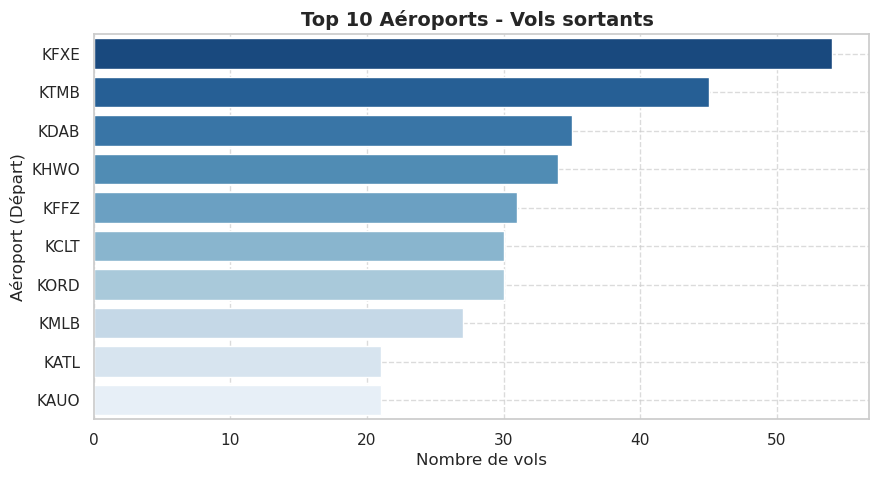

/tmp/ipykernel_424/71589102.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


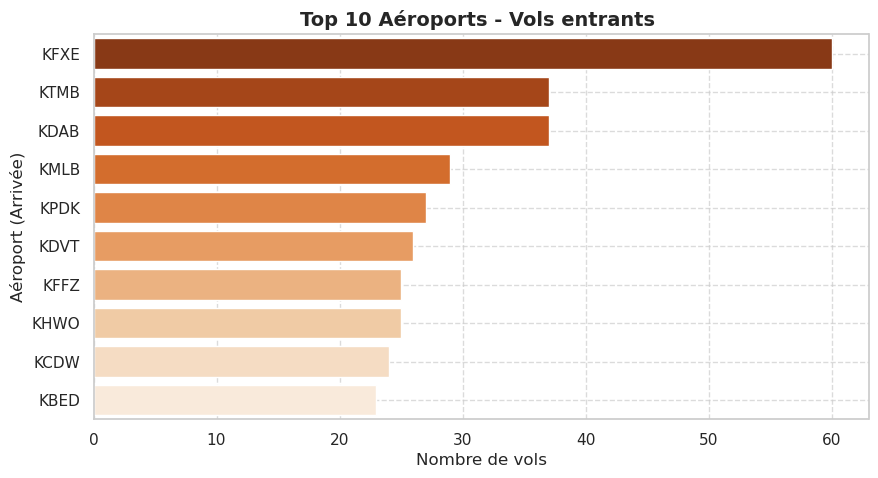

25/02/18 14:02:47 ERROR TaskSchedulerImpl: Lost executor 0 on 172.23.0.6: worker lost: Not receiving heartbeat for 60 seconds
25/02/18 14:02:47 WARN HeartbeatReceiver: Removing executor 0 with no recent heartbeats: 129650 ms exceeds timeout 120000 ms
25/02/18 14:02:47 WARN StandaloneSchedulerBackend: Executor to kill 0 does not exist!


In [10]:
outbound_pd = outbound.limit(10).toPandas()
inbound_pd = inbound.limit(10).toPandas()

# 🎨 Configurer le style Seaborn
sns.set_theme(style="whitegrid", palette="muted")

# 📈 Vols sortants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_sortants",
    y="estDepartureAirport",
    data=outbound_pd,
    palette="Blues_r"
)
plt.title("Top 10 Aéroports - Vols sortants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Départ)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 📊 Vols entrants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_entrants",
    y="estArrivalAirport",
    data=inbound_pd,
    palette="Oranges_r"
)
plt.title("Top 10 Aéroports - Vols entrants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Arrivée)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()